# PRELIMINARES: Detección de Neumonía a partir de imágenes de rayos X
### **P3:** Aprendizaje Profundo - CICESE

> **Estudiante:** [Joel Ricci López](https://github.com/jRicciL), 2021

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/jRicciL/Aprendizaje_profundo_tareas_CICESE/blob/master/Tarea_3_CNN/P3_Preprocess_CNN_Pneumonia.ipynb)



***

Este notebook contiene únicamente la fase de obtención y manipulación inicial del conjunto de datos.

<h3 style='font-weight: bold'>
<font color='red'>El notebook principal es el siguiente:</font>
</h3>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/jRicciL/Aprendizaje_profundo_tareas_CICESE/blob/master/Tarea_3_CNN/P3_ConvolutionalNN_PNEUMONIA_X_ray.ipynb)

<br>

***
## Obtención del conjunto de datos
Intalación y acceso a Kaggle desde Colab.
```python
from google.colab import files
files.upload()

!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json
```
Código para poder accesar a drive desde Colab. Esta celda la dejamos disponible para ejecutarla en cada sesión.
```python
from google.colab import drive

drive.mount('/content/gdrive')
root_path = 'gdrive/My Drive/ap-jrl-neumonia/'
```

Descarga del dataset al directorio de drive.
```
!kaggle datasets download paultimothymooney/chest-xray-pneumonia -p /content/gdrive/My\ Drive/kaggle/ap-jrl-neumonia
```

Descomprime el archivo .zip en el directorio indicado
```python
# Descomprimimos el archivo
import zipfile
with zipfile.ZipFile(f'{root_path}/chest-xray-pneumonia.zip', 'r') as zf:
  zf.extractall(root_path)
```

## Librerías usadas

In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid', context='talk', palette='Spectral')

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive/')
root_path = '/content/gdrive/My Drive/kaggle/ap-jrl-neumonia/chest_xray'
%cd $root_path/
%ls

Mounted at /content/gdrive/
/content/gdrive/My Drive/kaggle/ap-jrl-neumonia/chest_xray
chest_xray/  __MACOSX/  test/  train/  val/


## Conjunto de datos

In [ ]:
# Verificamos que las imágenes se encuentren en su directorio correspondiente
# Variables con los paths a los directorios de cada conjunto
test_dir = os.path.join(root_path, 'test')
train_dir = os.path.join(root_path, 'train')
val_dir = os.path.join(root_path, 'val')

# Contamos el número de imágenes pertenecientes a cada conjunto
def count_samples():
  samples = {}
  for set_ in ['test', 'train', 'val']:
    samples[set_] = {}
    for class_ in ['NORMAL', 'PNEUMONIA']:
      path = os.path.join(root_path, set_)
      k = len(os.listdir(f'{path}/{class_}'))
      samples[set_].update({class_: k})
  # Almacenamos los datos en un pequeño dataframe
  df_samples = pd.DataFrame(samples)
  return df_samples

df_samples = count_samples()

,test,train,val
NORMAL,234,1341,8
PNEUMONIA,390,3875,8


Num. de casos positivos: 4273 = 0.73
Num. de casos negativos: 1583 = 0.27


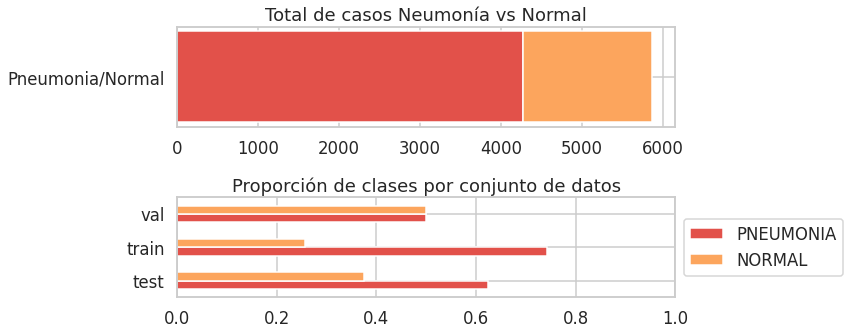

In [ ]:
# Número total de observaciones
n = df_samples.values.sum()
# Número de casos positivos y de casos negativos
n_neg, n_pos = df_samples.sum(axis = 1).values

print(f'Num. de casos positivos: {n_pos} = {n_pos / n:.2f}')
print(f'Num. de casos negativos: {n_neg} = {n_neg / n:.2f}')

# Visualización
fig, ax = plt.subplots(2,1, figsize=(10, 5))
# Número total de casos
ax[0].barh(['Pneumonia/Normal'], [n_pos])
ax[0].barh(['Pneumonia/Normal'], [n_neg], left=[n_pos])
ax[0].set(title='Total de casos Neumonía vs Normal')
# Proporción de etiquetas por set
(df_samples / df_samples.sum()).iloc[::-1].T.plot(kind='barh', ax = ax[1],
      xlim=(0, 1), title='Proporción de clases por conjunto de datos')
plt.tight_layout()
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

- **El conjunto de datos está desbalanceado**, con el 73% de muestras positivas y el 27% de muestras negativas.
- Además, **dicho desbalance no es el mismo** entre los tres conjuntos de datos (`train`, `test`, y `validation`).

In [ ]:
import shutil
# Definir cuantas imagenes mover del set de entrenamiento a los otros sets

def n_files_to_move(pct=0.75, subset='train'):
  '''Indica el número imágenes positivas y negativas a 
  mover desde el `subse` indicado'''
  # Valores ideales para cumplir con el ptc indicado
  n_train = int(n * pct)
  p_pos_T = n_pos / n
  n_pos_T = int(n_train * p_pos)
  p_neg_T = n_neg / n
  n_neg_T = int(n_train * p_neg)
  # Valores reales
  pos_to_move = n_pos_T - df_samples.loc['PNEUMONIA', subset]
  neg_to_move = n_neg_T - df_samples.loc['NORMAL', subset]
  return (pos_to_move, neg_to_move)

def move_images_from_dir(from_dir, to_dir, n_pos, n_neg):
  for dir, k in zip(['PNEUMONIA', 'NORMAL'], [n_pos, n_neg]):
    if k <= 0:
      continue
    from_ = f'{from_dir}/{dir}/'
    files = os.listdir(from_)
    files = np.random.choice(files, size=k, replace=False)
    for file in files:
      shutil.move(f'{from_}/{file}', f'{to_dir}/{dir}/')
    print(50*'*' + '\n', 
          f'Se movieron {k} archivos de {from_dir}/{dir} a {to_dir}/{dir} ')

In [ ]:
n_post_test, n_neg_test = n_files_to_move(0.1, 'test')
# Movemos los archivos de train a test
move_images_from_dir(train_dir, test_dir, n_post_test, n_neg_test)

df_samples = count_samples()
n_files_to_test = n_files_to_move(0.1, 'test')
n_files_to_test

**************************************************
 Se movieron 36 archivos de /content/gdrive/My Drive/kaggle/ap-jrl-neumonia/chest_xray/train/PNEUMONIA a /content/gdrive/My Drive/kaggle/ap-jrl-neumonia/chest_xray/test/PNEUMONIA 


(0, -76)

In [ ]:
# Ahora hay que mover 76 archivos negativos de test a validacion
move_images_from_dir(test_dir, val_dir, 0, 76)

df_samples = count_samples()
n_files_to_test = n_files_to_move(0.1, 'test')
n_files_to_test

**************************************************
 Se movieron 76 archivos de /content/gdrive/My Drive/kaggle/ap-jrl-neumonia/chest_xray/test/NORMAL a /content/gdrive/My Drive/kaggle/ap-jrl-neumonia/chest_xray/val/NORMAL 


(0, 0)

In [ ]:
# Finalmente, movemos archivos de train a validacion
n_post_val, n_neg_val = n_files_to_move(0.1, 'val')
# Movemos los archivos de train a test
move_images_from_dir(train_dir, val_dir, n_post_val, n_neg_val)

df_samples = count_samples()
n_files_to_val = n_files_to_move(0.1, 'val')
n_files_to_val

**************************************************
 Se movieron 418 archivos de /content/gdrive/My Drive/kaggle/ap-jrl-neumonia/chest_xray/train/PNEUMONIA a /content/gdrive/My Drive/kaggle/ap-jrl-neumonia/chest_xray/val/PNEUMONIA 
**************************************************
 Se movieron 74 archivos de /content/gdrive/My Drive/kaggle/ap-jrl-neumonia/chest_xray/train/NORMAL a /content/gdrive/My Drive/kaggle/ap-jrl-neumonia/chest_xray/val/NORMAL 


(0, 0)

Num. de casos positivos: 4273 = 0.73
Num. de casos negativos: 1583 = 0.27


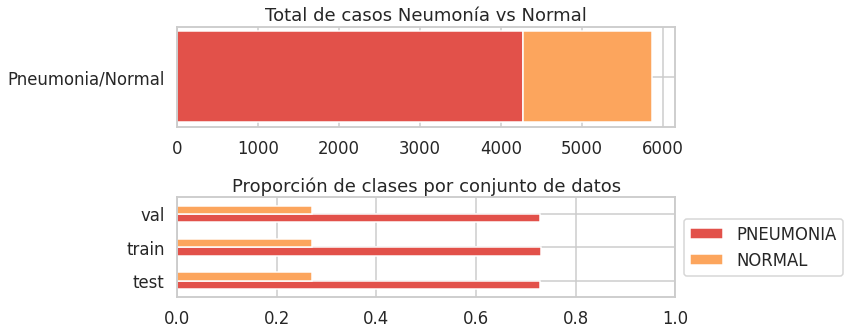

In [ ]:
# Número total de observaciones
n = df_samples.values.sum()
# Número de casos positivos y de casos negativos
n_neg, n_pos = df_samples.sum(axis = 1).values

print(f'Num. de casos positivos: {n_pos} = {n_pos / n:.2f}')
print(f'Num. de casos negativos: {n_neg} = {n_neg / n:.2f}')

# Visualización
fig, ax = plt.subplots(2,1, figsize=(10, 5))
# Número total de casos
ax[0].barh(['Pneumonia/Normal'], [n_pos])
ax[0].barh(['Pneumonia/Normal'], [n_neg], left=[n_pos])
ax[0].set(title='Total de casos Neumonía vs Normal')
# Proporción de etiquetas por set
(df_samples / df_samples.sum()).iloc[::-1].T.plot(kind='barh', ax = ax[1],
      xlim=(0, 1), title='Proporción de clases por conjunto de datos')
plt.tight_layout()
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

# Referencias

1. Mariano Rivera (2018). **[Reeuso de Redes Preentrenadas](http://personal.cimat.mx:8181/~mrivera/cursos/aprendizaje_profundo/preentrenadas/preentrenadas.html)**. *Consultado el 18 de marzo del 2021.*
2. Eunjoo Byeon (2020). **[Exploratory Data Analysis Ideas for Image Classification](https://towardsdatascience.com/exploratory-data-analysis-ideas-for-image-classification-d3fc6bbfb2d2)**. En towardsdatascience.com. *Consultado el 18 de marzo del 2021.*
3. Paul Mooney (2018). **[Chest X-Ray Images (Pneumonia)](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia)**. En kaggle.com. *Consultado el 18 de marzo del 2021.*
4. Chollet, Francois (2017). **Deep Learning with Python.** New York, NY: Manning Publications.